In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!kaggle datasets download -d soumikrakshit/lol-dataset

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/lol-dataset
License(s): unknown
100% 331M/331M [00:16<00:00, 24.3MB/s]
100% 331M/331M [00:16<00:00, 21.1MB/s]


In [4]:
!unzip lol-dataset.zip -d /content/lol-dataset

Archive:  lol-dataset.zip
  inflating: /content/lol-dataset/lol_dataset/eval15/high/1.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/111.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/146.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/179.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/22.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/23.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/493.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/547.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/55.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/665.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/669.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/748.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/778.png  
  inflating: /content/lol-dataset/lol_dataset/eval15/high/780.png  
  inflating: /content/lol-d

In [ ]:
low_light_dir = "/content/lol-dataset/low"
well_lit_dir = "/content/lol-dataset/high"

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class LoLDataset(Dataset):
    def __init__(self, low_light_dir, well_lit_dir, transform=None):
        self.low_light_dir = low_light_dir
        self.well_lit_dir = well_lit_dir
        self.transform = transform
        self.image_pairs = []

        # Collect pairs of low-light and well-lit images
        for root, _, files in os.walk(low_light_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    input_path = os.path.join(root, file)
                    target_path = os.path.join(well_lit_dir, file)
                    if os.path.exists(target_path):
                        self.image_pairs.append((input_path, target_path))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, target_path = self.image_pairs[idx]
        try:
            input_image = Image.open(input_path).convert('RGB')
            target_image = Image.open(target_path).convert('RGB')
        except:
            print(f"Error opening images: {input_path}, {target_path}")
            return None, None

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define dataset paths
low_light_dir = "/content/lol-dataset/lol_dataset/our485/high"
well_lit_dir = "/content/lol-dataset/lol_dataset/our485/low"

# Check if the directories exist
if not os.path.exists(low_light_dir):
    print(f"The directory {low_light_dir} does not exist.")
if not os.path.exists(well_lit_dir):
    print(f"The directory {well_lit_dir} does not exist.")

dataset = LoLDataset(low_light_dir, well_lit_dir, transform=transform)

if len(dataset) > 0:
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
else:
    print("The dataset is empty. Please check the provided directories.")
    train_loader = None
    val_loader = None

In [ ]:
import random
if len(dataset) > 0:
    # Print sample pairs of loaded images
    sample_pairs = random.sample(dataset.image_pairs, k=5)  # Change the value of k to the desired number of sample pairs
    for input_path, target_path in sample_pairs:
        print(f"Input Image: {input_path}")
        print(f"Target Image: {target_path}")
        print()
else:
    print("Dataset does not have any images.")

Input Image: /content/lol-dataset/lol_dataset/our485/high/495.png
Target Image: /content/lol-dataset/lol_dataset/our485/low/495.png

Input Image: /content/lol-dataset/lol_dataset/our485/high/204.png
Target Image: /content/lol-dataset/lol_dataset/our485/low/204.png

Input Image: /content/lol-dataset/lol_dataset/our485/high/126.png
Target Image: /content/lol-dataset/lol_dataset/our485/low/126.png

Input Image: /content/lol-dataset/lol_dataset/our485/high/762.png
Target Image: /content/lol-dataset/lol_dataset/our485/low/762.png

Input Image: /content/lol-dataset/lol_dataset/our485/high/757.png
Target Image: /content/lol-dataset/lol_dataset/our485/low/757.png



In [ ]:
import torchvision.transforms as transforms

# Define the generator architecture
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, in_channels=6):
        super(Discriminator, self).__init__()

        # Modification: Add more layers to increase model capacity
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        input = torch.cat([x, y], dim=1)
        return self.model(input)

In [ ]:
# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Move models to GPU if available
# Set device to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to the device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
else:
    print("Using a single GPU or CPU")
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Learning rates
lr = 0.0001

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Number of epochs
num_epochs = 100

# Lambda for L1 loss
lambda_l1 = 100

class PairedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = os.listdir(join(root_dir, 'low'))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        low_image = Image.open(join(self.root_dir, 'low', img_name))
        high_image = Image.open(join(self.root_dir, 'high', img_name))

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

# Data loaders
transform = Compose([Resize((256, 256)), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = PairedImageFolder('/content/lol-dataset/lol_dataset/our485', transform=transform)
val_dataset = PairedImageFolder('/content/lol-dataset/lol_dataset/eval15', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using a single GPU or CPU


# DO NOT RUN THE BELOW ONE .IT IS A  DIFFERENT VERSION OF THE CODE TO THE CODE BELOW THIS. IT IS JUST A REFERENCE FOR CORRECTION

In [ ]:
ssim_values = []
epoch_numbers = []

# Training loop
for epoch in range(num_epochs):
    for input_images, target_images in train_loader:
        input_images = input_images.to(device)
        target_images = target_images.to(device)

        # Train the discriminator
        d_optimizer.zero_grad()

        # Generate fake images
        fake_images = generator(input_images)

        # Compute discriminator loss on real and fake images
        real_output = discriminator(input_images, target_images)
        fake_output = discriminator(input_images, fake_images.detach())

        real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        fake_images = generator(input_images)

        # Compute generator loss
        fake_output = discriminator(input_images, fake_images)
        g_adversarial_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
        g_l1_loss = l1_loss(fake_images, target_images)
        g_loss = g_adversarial_loss + lambda_l1 * g_l1_loss

        g_loss.backward()
        g_optimizer.step()

    # Evaluate on the validation set
    generator.eval()
    discriminator.eval()
    val_ssim_scores = []
    val_psnr_scores = []
    generated_images_all = []
    for input_images, target_images in val_loader:
        input_images = input_images.to(device)
        target_images = target_images.to(device)

        with torch.no_grad():
            generated_images = generator(input_images)
            generated_images_np = generated_images.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)
            target_images_np = target_images.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)

            # Compute SSIM
            ssim = structural_similarity(
                generated_images_np,
                target_images_np,
                multichannel=True,
                win_size=3,
                data_range=1
            )
            val_ssim_scores.append(ssim)

            # Compute PSNR
            psnr = 0.0
            for i in range(generated_images_np.shape[0]):
                psnr += peak_signal_noise_ratio(target_images_np[i], generated_images_np[i])
            val_psnr_scores.append(psnr / generated_images_np.shape[0])

            # Collect generated images for visualization
            generated_images_all.extend(generated_images)

    val_avg_ssim = sum(val_ssim_scores) / len(val_ssim_scores)
    val_avg_psnr = sum(val_psnr_scores) / len(val_psnr_scores)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation SSIM: {val_avg_ssim:.4f}, Validation PSNR: {val_avg_psnr:.4f}')

    # Store the SSIM value and epoch number for plotting
    ssim_values.append(val_avg_ssim)
    epoch_numbers.append(epoch + 1)

    generator.train()
    discriminator.train()

# Plotting generated images
num_images = len(generated_images_all)

if num_images > 0:
    nrows = int(np.ceil(np.sqrt(num_images)))
    ncols = int(np.ceil(num_images / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = generated_images_all[i].permute(1, 2, 0).detach().cpu().numpy()
            image = (image * 0.5 + 0.5) * 255  # Rescale to [0, 255]
            image = image.astype(np.uint8)
            ax.imshow(image)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No generated images to display.")

# Return the model to training mode
generator.train()
discriminator.train()


In [ ]:
ssim_values = []
epoch_numbers = []

# Training loop
for epoch in range(num_epochs):
    for input_images, target_images in train_loader:
        input_images = input_images.to(device)
        target_images = target_images.to(device)

        # Train the discriminator
        d_optimizer.zero_grad()

        # Generate fake images
        fake_images = generator(input_images)

        # Compute discriminator loss on real and fake images
        real_output = discriminator(input_images, target_images)
        fake_output = discriminator(input_images, fake_images.detach())

        real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        fake_images = generator(input_images)

        # Compute generator loss
        fake_output = discriminator(input_images, fake_images)
        g_adversarial_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
        g_l1_loss = l1_loss(fake_images, target_images)
        g_loss = g_adversarial_loss + lambda_l1 * g_l1_loss

        g_loss.backward()
        g_optimizer.step()

    # Evaluate on the validation set
    generator.eval()
    discriminator.eval()
    val_ssim_scores = []
    val_psnr_scores = []
    generated_images_all = []
    for input_images, target_images in val_loader:
        input_images = input_images.to(device)
        target_images = target_images.to(device)

        with torch.no_grad():
            generated_images = generator(input_images)
            generated_images_np = generated_images.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)
            target_images_np = target_images.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)

            # Compute SSIM
            ssim = structural_similarity(
                generated_images_np,
                target_images_np,
                multichannel=True,
                win_size=3,
                data_range=1
            )
            val_ssim_scores.append(ssim)

            # Compute PSNR
            psnr = 0.0
            for i in range(generated_images_np.shape[0]):
                psnr += peak_signal_noise_ratio(target_images_np[i], generated_images_np[i])
            val_psnr_scores.append(psnr / generated_images_np.shape[0])

            # Collect generated images for visualization
            generated_images_all.extend(generated_images)

    val_avg_ssim = sum(val_ssim_scores) / len(val_ssim_scores)
    val_avg_psnr = sum(val_psnr_scores) / len(val_psnr_scores)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation SSIM: {val_avg_ssim:.4f}, Validation PSNR: {val_avg_psnr:.4f}')

    # Store the SSIM value and epoch number for plotting
    ssim_values.append(val_avg_ssim)
    epoch_numbers.append(epoch + 1)

    generator.train()
    discriminator.train()

# Plotting generated images
num_images = len(generated_images_all)

if num_images > 0:
    nrows = int(np.ceil(np.sqrt(num_images)))
    ncols = int(np.ceil(num_images / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = generated_images_all[i].permute(1, 2, 0).detach().cpu().numpy()
            image = (image * 0.5 + 0.5) * 255  # Rescale to [0, 255]
            image = image.astype(np.uint8)
            ax.imshow(image)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No generated images to display.")

# Return the model to training mode
generator.train()
discriminator.train()


Epoch [1/100], Validation SSIM: 0.0116, Validation PSNR: 12.9941
Epoch [2/100], Validation SSIM: 0.1046, Validation PSNR: 14.0714
Epoch [3/100], Validation SSIM: -0.0092, Validation PSNR: 13.3771
Epoch [4/100], Validation SSIM: 0.0345, Validation PSNR: 9.1659
Epoch [5/100], Validation SSIM: 0.0683, Validation PSNR: 11.8497
Epoch [6/100], Validation SSIM: -0.0296, Validation PSNR: 9.8559
Epoch [7/100], Validation SSIM: 0.0171, Validation PSNR: 13.6222
Epoch [8/100], Validation SSIM: 0.1265, Validation PSNR: 14.0923
Epoch [9/100], Validation SSIM: 0.0249, Validation PSNR: 9.2077
Epoch [10/100], Validation SSIM: 0.0876, Validation PSNR: 11.6430


KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')

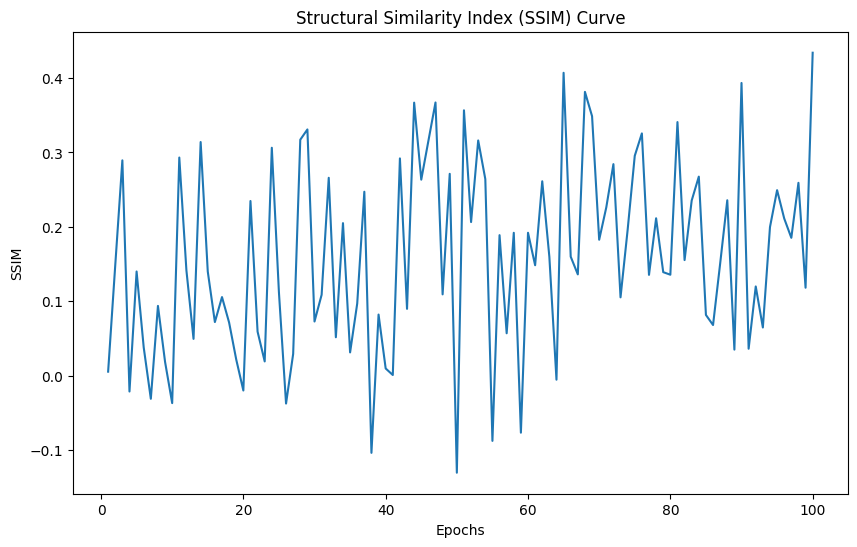

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, ssim_values)
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('Structural Similarity Index (SSIM) Curve')
plt.show()

<ipython-input-26-04f7624f6b95>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))


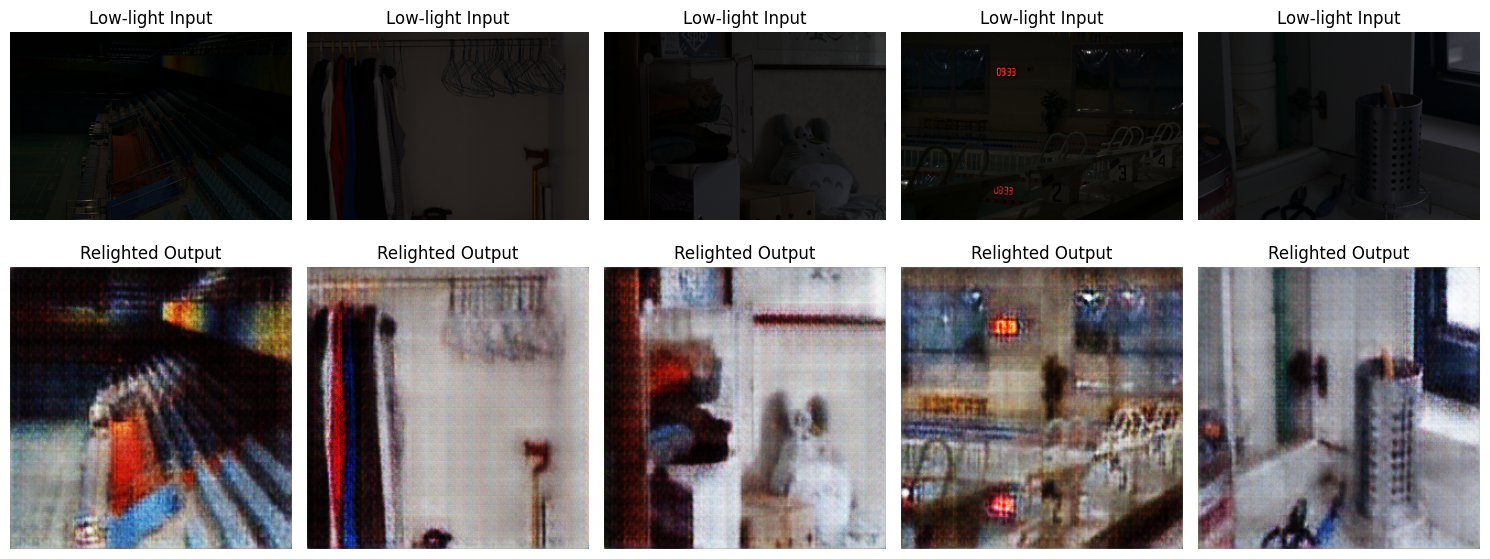

In [ ]:
# Load the trained generator for inference
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Transform for input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and preprocess some sample low-light images
low_light_dir = '/content/lol-dataset/lol_dataset/eval15/low'
image_files = [os.path.join(low_light_dir, f) for f in os.listdir(low_light_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:5]
sample_low_light_images = [Image.open(img_file) for img_file in image_files]
sample_input_tensors = [transform(img).unsqueeze(0).to(device) for img in sample_low_light_images]

# Generate and display sample relighted images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, input_tensor in enumerate(sample_input_tensors):
    with torch.no_grad():
        relighted_image = generator(input_tensor)[0]

    relighted_image = relighted_image.permute(1, 2, 0).detach().cpu().numpy()
    relighted_image = (relighted_image * 0.5 + 0.5) * 255
    relighted_image = relighted_image.astype(np.uint8)

    axes[0, i].imshow(sample_low_light_images[i])
    axes[0, i].set_title('Low-light Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(relighted_image)
    axes[1, i].set_title('Relighted Output')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Open CV [DO NOT RUN]

In [ ]:
import cv2
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import numpy as np

# Load the trained generator
generator.load_state_dict(torch.load('generator.pth', map_location=torch.device('cpu')))
generator.eval()
generator.to(device)

# Define preprocessing transformations
transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Start video capture
cap = cv2.VideoCapture(0)  # 0 is the default camera

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    # Convert the frame to RGB and preprocess
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_image = transform(Image.fromarray(frame_rgb)).unsqueeze(0).to(device)

    # Generate the enhanced image
    with torch.no_grad():
        enhanced_image = generator(input_image)[0]

    # Convert the enhanced image back to numpy format
    enhanced_image = enhanced_image.permute(1, 2, 0).detach().cpu().numpy()
    enhanced_image = (enhanced_image * 0.5 + 0.5) * 255  # Rescale to [0, 255]
    enhanced_image = enhanced_image.astype(np.uint8)

    # Convert enhanced image to BGR for OpenCV
    enhanced_image_bgr = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR)

    # Display both original and enhanced frames side by side
    combined_frame = np.hstack((frame, enhanced_image_bgr))
    cv2.imshow("Low-Light Input vs Enhanced Output", combined_frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
generator = Generator()
discriminator = Discriminator()

# Load the pre-trained weights
generator.load_state_dict(torch.load('/content/LLIE_GAN_MODEL(P&W).pth', map_location=torch.device('cpu')), strict=False)
discriminator.load_state_dict(torch.load('/content/LLIE_GAN_MODEL(P&W).pth', map_location=torch.device('cpu')), strict=False)

# Set models to evaluation mode
generator.eval()
discriminator.eval()

# If you're using CUDA, you can move the models to GPU:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

<ipython-input-15-01c37f5673cb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/LLIE_GAN_MODEL(P&W).pth', map_location=torch.

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (12): Sigmoid()
  )
)

In [ ]:
# Check the keys in the pre-trained model
checkpoint = torch.load('/content/LLIE_GAN_MODEL(P&W).pth', map_location=torch.device('cpu'))
print(checkpoint.keys())  # List all keys in the checkpoint

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.3.running_mean', 'encoder.3.running_var', 'encoder.3.num_batches_tracked', 'encoder.5.weight', 'encoder.5.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.6.running_mean', 'encoder.6.running_var', 'encoder.6.num_batches_tracked', 'encoder.8.weight', 'encoder.8.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.9.running_mean', 'encoder.9.running_var', 'encoder.9.num_batches_tracked', 'decoder.0.weight', 'decoder.0.bias', 'decoder.1.weight', 'decoder.1.bias', 'decoder.1.running_mean', 'decoder.1.running_var', 'decoder.1.num_batches_tracked', 'decoder.3.weight', 'decoder.3.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.4.running_mean', 'decoder.4.running_var', 'decoder.4.num_batches_tracked', 'decoder.6.weight', 'decoder.6.bias', 'decoder.7.weight', 'decoder.7.bias', 'decoder.7.running_mean', 'decoder.7.running_var', 'decoder.7.num_batches_

<ipython-input-16-5b9f6d502ca0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/LLIE_GAN_MODEL(P&W).pth', map_location=torch.device('cpu')

In [ ]:
import cv2
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import numpy as np
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
import os

# Define the Generator model class (no changes needed)
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class LowLightEnhancer:
    def __init__(self, generator_model_path, discriminator_model_path, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load the trained models
        self.generator = self._load_generator_model(generator_model_path)
        self.discriminator = self._load_discriminator_model(discriminator_model_path)

        # Define preprocessing transformations
        self.transform = Compose([
            Resize((256, 256)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
        ])

    def _load_generator_model(self, model_path):
        generator = Generator()  # Using the defined Generator class
        generator.load_state_dict(torch.load(model_path, map_location=self.device), strict=False)
        generator.eval()
        return generator.to(self.device)

    def _load_discriminator_model(self, model_path):
        discriminator = Discriminator()  # Using the defined Discriminator class
        discriminator.load_state_dict(torch.load(model_path, map_location=self.device), strict=False)
        discriminator.eval()
        return discriminator.to(self.device)

    def enhance_frame(self, frame):
        # Convert the frame to RGB and preprocess
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_image = self.transform(Image.fromarray(frame_rgb)).unsqueeze(0).to(self.device)

        # Generate the enhanced image
        with torch.no_grad():
            enhanced_image = self.generator(input_image)[0]

        # Convert the enhanced image back to numpy format
        enhanced_image = enhanced_image.permute(1, 2, 0).detach().cpu().numpy()
        enhanced_image = (enhanced_image * 0.5 + 0.5) * 255  # Rescale to [0, 255]
        enhanced_image = enhanced_image.astype(np.uint8)

        # Convert the enhanced image to BGR for OpenCV
        enhanced_image_bgr = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR)
        return enhanced_image_bgr

    def process_video(self, video_path):
      cap = cv2.VideoCapture(video_path)

      if not cap.isOpened():
        print("Error: Could not open video.")
        return

      while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or error.")
            break

        # Resize the original frame to match the enhanced image size (256x256)
        original_resized = cv2.resize(frame, (256, 256))

        # Enhance the frame
        enhanced_image_bgr = self.enhance_frame(frame)

        # Display both original and enhanced frames side by side
        combined_frame = np.hstack((original_resized, enhanced_image_bgr))
        cv2_imshow(combined_frame)

        # Add delay to mimic real-time processing
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

      cap.release()
      cv2.destroyAllWindows()



# Main code to run the video enhancement
if __name__ == "__main__":
    # Assuming video is uploaded to the '/content' folder (this is the default location)
    video_file = '/content/LLV2.mp4'  # Change this to the path of your uploaded video file

    generator_model_path = '/content/LLIE_GAN_MODEL(P&W).pth'  # Path to the generator model weights
    discriminator_model_path = '/content/LLIE_GAN_MODEL(P&W).pth'  # Path to the discriminator model weights (if separate)

    # Initialize the low light enhancer
    enhancer = LowLightEnhancer(generator_model_path, discriminator_model_path)

    # Process the uploaded video
    enhancer.process_video(video_file)